# Scale-Invariant form of TOV equations

In this notebook, one can find the algorithm to numerically solve the scale-invariant form of the TOV equations using the Runge-Kutta method. This code is highly recommended for beginners who are not familiar with more complex code, like TWO-FLUIDS code. The scale-invariant form of TOV equations are the form:

\begin{equation*}
\begin{split}
    \frac{dp'}{dr'} &= -\frac{Gm}{r'^2}\Big(1 + \frac{p'}{\rho'}\Big)\Big(1+\frac{4\pi r'^3 p'}{m'}\Big)\Big(1-\frac{2Gm'}{r'}\Big)^{-1}\\
    \frac{dm'}{dr'} &= 4\pi r'^2\rho'
\end{split}
\end{equation*}
where
\begin{equation*}
 p' = p/\epsilon_{0} ,\quad \rho' = \rho/\epsilon_{0}, ,\quad     m' = m/b ,\qquad  r' = r/a;.
\end{equation*}
with
\begin{equation*}
    a = \frac{1}{\sqrt{G\epsilon_{0}}}\quad\text{and}\quad b = \frac{1}{\sqrt{G^3\epsilon_{0}}}
\end{equation*}

In [ ]:
# Import libraries
# ==============================================================================
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from tqdm import tqdm

In [ ]:
# Define the constants and parameters
# =============================================================================
G = 6.674e-11                         # Gravitational constant in SI
c = 2.9979e8                          # Speed of light in SI
M_sun = 1.989e30                      # Mass of the Sun in SI
R_sun = 6.9634e8                      # Radius of the Sun in SI
hbar = 1.054571800*10**(-34)          # Bar Planck constant in SI
el = 1.60217662*10**(-19)
B = 145**4                            # Bag Constant in MeV
BSI1 = 4*92.63703e32
BSI = 4*B/((hbar*c)/(10**6*el))**3
pi = np.pi


a = c/(G*BSI)**(1/2)
b = c**3/(G**3*BSI)**(1/2)

In [ ]:
# Equation of state for BAG model
# =============================================================================
def EoS(e):
  """Equation of State: Pressure as a function of energy density"""
  return (e-1)/3


def EoS_rho(p):
  """Equation of State: Energy as a function of pressure"""
  return (3.0*p + 1)


# System of adimensional differential equations for TOV"""
# ==============================================================================
def dmdr(r, m, p, e):
  ''' First TOV equation'''
  return 4.0 * pi * r**2 * e

def dpdr(r, m, p, e):
  ''' Second TOV equation'''
  return -(p + e)*(m + 4*pi*r**3*p) / (r *(r - 2*m))


# Solving the differential equation
# ==============================================================================
def RK4(e0):
    ''' Implementation of Runge-Kutta method for solving TOV's equations '''
    # Initial conditions
    # ==========================================================================
    e = e0
    dr = 1e-3
    r = 1e-3
    m = 1e-5
    P = EoS(e0)


    # Defining the Runga-Kutta parameter
    # ==========================================================================
    km = np.ones(4)
    kp = np.ones(4)

    # Define arrays to store the values of radii, mass, and pressure
    # ==========================================================================
    radii = np.array([])
    mass = np.array([])
    pressure = np.array([])
    energy = np.array([])


    while ( P >= 0):
        km[0] = dr*dmdr(r, m, P, e)
        kp[0] = dr*dpdr(r, m, P, e)

        e = EoS_rho(P+kp[0]/2)
        km[1] = dr*dmdr(r + dr/2, m+km[0]/2,P + kp[0]/2, e)
        kp[1] = dr*dpdr(r + dr/2, m+km[0]/2,P + kp[0]/2, e)


        e = EoS_rho(P+kp[1]/2)
        km[2] = dr*dmdr(r + dr/2, m + km[1]/2, P + kp[1]/2, e)
        kp[2] = dr*dpdr(r + dr/2, m + km[1]/2, P + kp[1]/2, e)

        e = EoS_rho(P+kp[2]/2)
        km[3] = dr*dmdr(r + dr, m + km[2], P + kp[2], e)
        kp[3] = dr*dpdr(r + dr, m + km[2], P + kp[2], e)


        P += 1/6 * (kp[0] + 2*(kp[1]+kp[2]) + kp[3])
        m += 1/6 * (km[0] + 2*(km[1]+km[2]) + km[3])
        r += dr
        e = EoS_rho(P)
        radii = np.append(radii,r)
        mass = np.append(mass,m)
        pressure = np.append(pressure,P)
        energy =  np.append(energy,e)

    return [radii, mass, pressure, energy]


## Profile of Mass, Pressure, and Energy

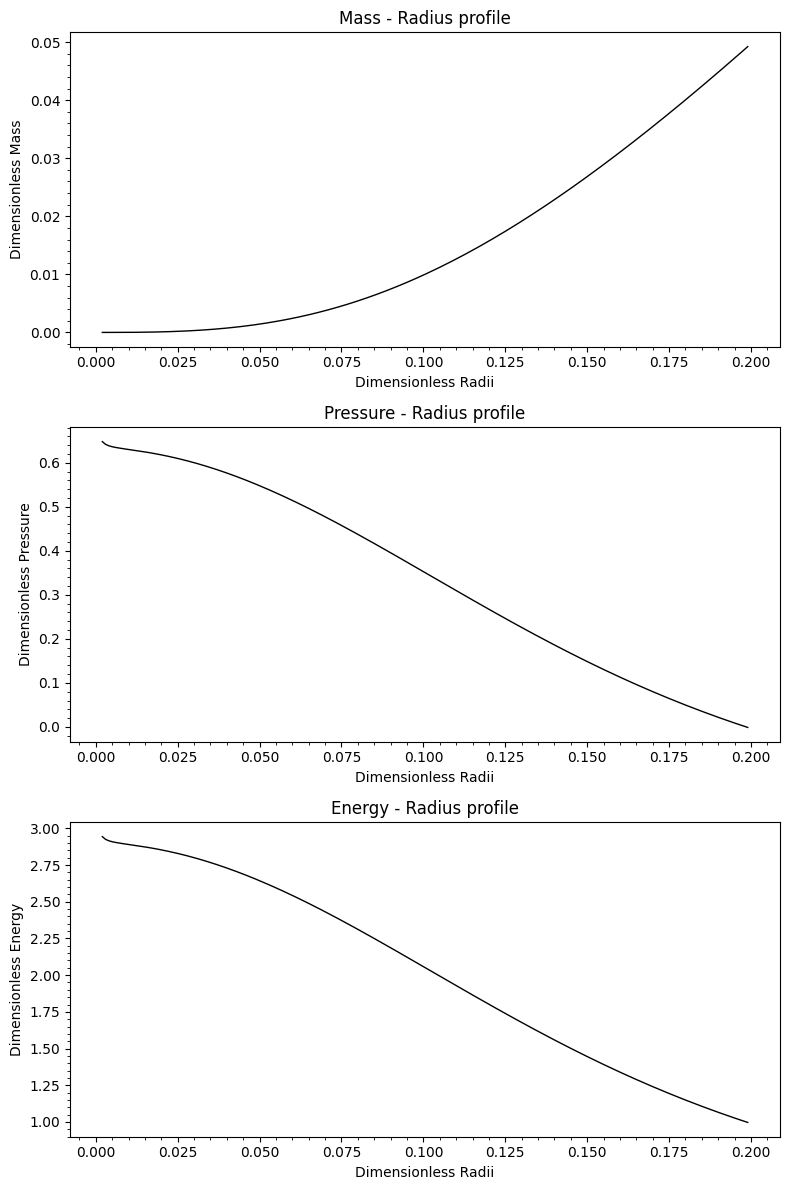

In [ ]:
radii, mass, pressure, energy = RK4(3)

fig, ax = plt.subplots(ncols = 1, nrows = 3,figsize=(8, 12))
# First figure
ax[0].plot(radii, mass,linewidth=1, color = 'black' )
ax[0].set_title('Mass - Radius profile')
ax[0].set_xlabel('Dimensionless Radii')
ax[0].set_ylabel('Dimensionless Mass')
ax[0].minorticks_on()

# Second figure
ax[1].plot(radii, pressure,linewidth=1, color = 'black' )
ax[1].set_title('Pressure - Radius profile')
ax[1].set_xlabel('Dimensionless Radii')
ax[1].set_ylabel('Dimensionless Pressure')
ax[1].minorticks_on()

# Third figure
ax[2].plot(radii, energy,linewidth=1, color = 'black' )
ax[2].set_title('Energy - Radius profile')
ax[2].set_xlabel('Dimensionless Radii')
ax[2].set_ylabel('Dimensionless Energy')
ax[2].minorticks_on()

plt.tight_layout()
plt.show()

## Mass-Radius Relation

100%|██████████| 150/150 [00:01<00:00, 99.17it/s]


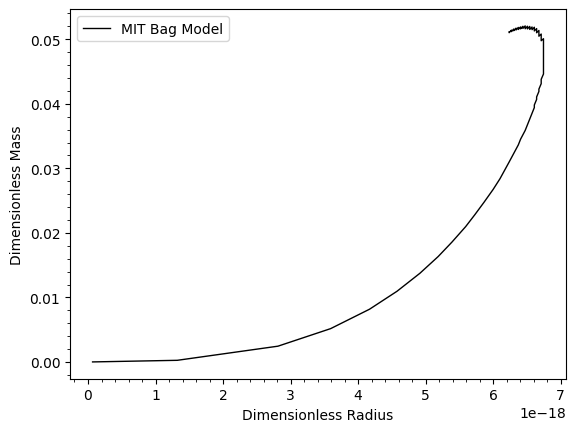

In [ ]:
def TOV(min,max):
  M = np.array([])
  R = np.array([])
  Ec = np.array([])
  rhorange  = np.linspace(min,max,150)
  for i in tqdm(rhorange):
    radii, mass, pressure, energy = RK4(i)
    R = np.append(R, radii[-1])
    M = np.append(M, mass[-1])
    Ec = np.append(Ec,energy[0])
  return [R,M,Ec]

R, M, Ec = TOV(1,7)

plt.plot(R,M,linewidth=1, color = 'black' , label = r'MIT Bag Model')
plt.xlabel(r'Dimensionless Radius')
plt.ylabel(r'Dimensionless Mass')

plt.legend(loc='upper left')
plt.minorticks_on()
plt.show()






## Stability  Condition

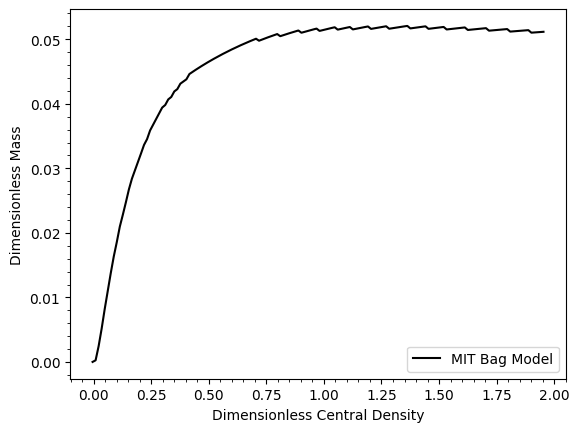

In [ ]:
plt.plot(Ec,M,  color = 'black' , label = r'MIT Bag Model')
plt.xlabel(r'Dimensionless Central Density')
plt.ylabel(r'Dimensionless Mass')

plt.legend(loc='lower right')
plt.minorticks_on()
plt.show()

## Compactness

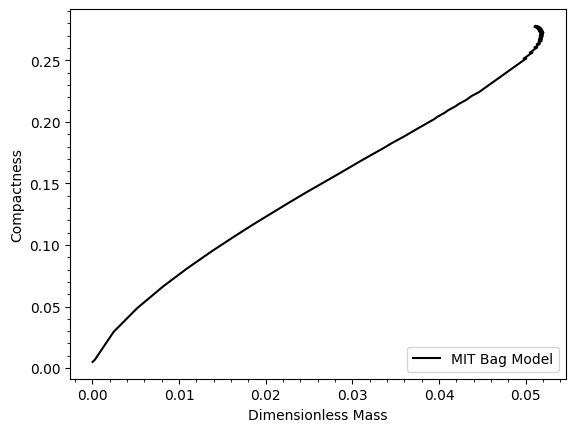

In [ ]:
C = M/R
plt.plot(M , C, color = 'black' , label = r'MIT Bag Model')
plt.ylabel(r'Compactness')
plt.xlabel(r'Dimensionless Mass')

plt.legend(loc='lower right')
plt.minorticks_on()
plt.show()

# References

G. Narain, J. Schaffner-Bielich, and I. N. Mishustin, *Compact stars made of fermionic dark matter*, ${\it Phys. Rev. D}$ 74, 063003 (2006). https://journals.aps.org/prd/abstract/10.1103/PhysRevD.74.063003